This tutorial is about
- Define neural-Jastrow as a correction to fermionic mean-field wave functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import equinox as eqx
import quantax as qtx
from quantax.symmetry import Identity, Trans2D, SpinInverse, C4v
from IPython.display import clear_output
%config InlineBackend.figure_format = 'svg'

# change default dtype to complex
qtx.set_default_dtype(jnp.complex128)

lattice = qtx.sites.Square(4, Nparticle=(8, 8)) # 4x4 square lattice
N = lattice.N

In [2]:
hamiltonian = qtx.operator.Heisenberg(J=[1, 0.5], n_neighbor=[1, 2])  # no msr

# When you want to load the trained MF wave function, define it again
mf = qtx.model.PfSinglet(sublattice=(2, 2), dtype=jnp.float64)

# Define a neural network to be combined with MF
net = qtx.model.ResSum(
    2, 8, 3, trans_symm=Identity()  # Identity means the last layer won't be summed
)

# Combine net and mf to make Neural-Jastrow wave function
model = qtx.model.NeuralJastrow(net, mf, trans_symm=Trans2D())

state = qtx.state.Variational(model, max_parallel=32768)

sampler = qtx.sampler.NeighborExchange(state, 1000, n_neighbor=[1, 2])
tdvp = qtx.optimizer.TDVP(state, hamiltonian)

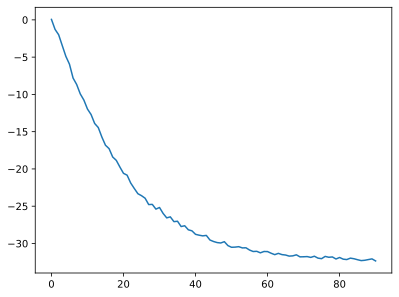

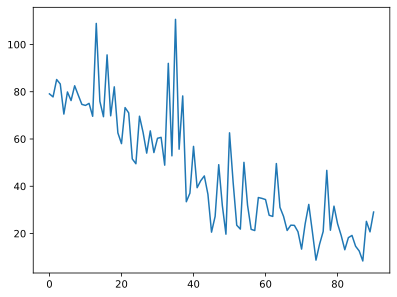

In [3]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(100):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    state.update(step * 1e-2)
    energy_data.append(tdvp.energy)
    VarE_data.append(tdvp.VarE)

    if i % 10 == 0:
        clear_output()
        energy_data.plot()
        plt.show()
        VarE_data.plot()
        plt.show()

In [4]:
state.save("/tmp/model.eqx")

In [5]:
# When you want to load the trained MF wave function, define it again
mf = qtx.model.PfSinglet(sublattice=(2, 2), dtype=jnp.float64)

# Define a neural network to be combined with MF
net = qtx.model.ResSum(
    2, 8, 3, trans_symm=Identity()  # Identity means the last layer won't be summed
)

# Combine net and mf to make Neural-Jastrow wave function
model = qtx.model.NeuralJastrow(net, mf, trans_symm=Trans2D())

state = qtx.state.Variational(
    model, 
    param_file="/tmp/model.eqx",  # Now the full model can be loaded here
    symm=SpinInverse() + C4v(), 
    max_parallel=32768,
)

sampler = qtx.sampler.NeighborExchange(state, 1000, n_neighbor=[1, 2])
tdvp = qtx.optimizer.TDVP(state, hamiltonian)

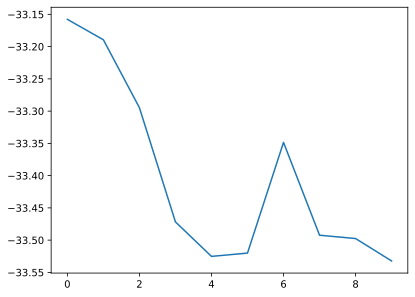

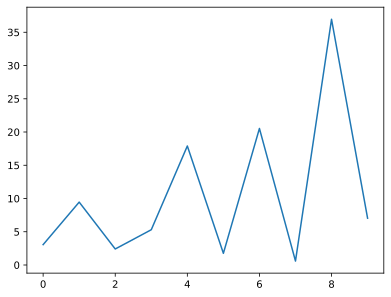

In [6]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(10):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    state.update(step * 1e-2)
    energy_data.append(tdvp.energy)
    VarE_data.append(tdvp.VarE)

    clear_output()
    energy_data.plot()
    plt.show()
    VarE_data.plot()
    plt.show()

In [7]:
# Check with the ED result
symm = SpinInverse() + C4v() + Trans2D()
E, wf = hamiltonian.diagonalize(symm)
print(E)

/mnt/home/achen1/quantax_env/lib/python3.10/site-packages/quantax/symmetry/symmetry.py:268: GeneralBasisWarning: using non-commuting symmetries can lead to unwanted behaviour of general basis, make sure that quantum numbers are invariant under non-commuting symmetries!
  basis = spin_basis_general(self.N, Nup, pauli=0, make_basis=False, **blocks)


[-33.83169341]
